# Data for TSP Warehouse

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv("fruits.csv")
df

,Name,Category
0,Abiu,Fruit
1,Açaí,Fruit
2,Acerola,Fruit
3,Akebi,Fruit
4,Ackee,Fruit
...,...,...
153,Pea,Fruit
154,Pumpkin,Fruit
155,Squash,Fruit
156,Tomato,Fruit


# Generate Graph

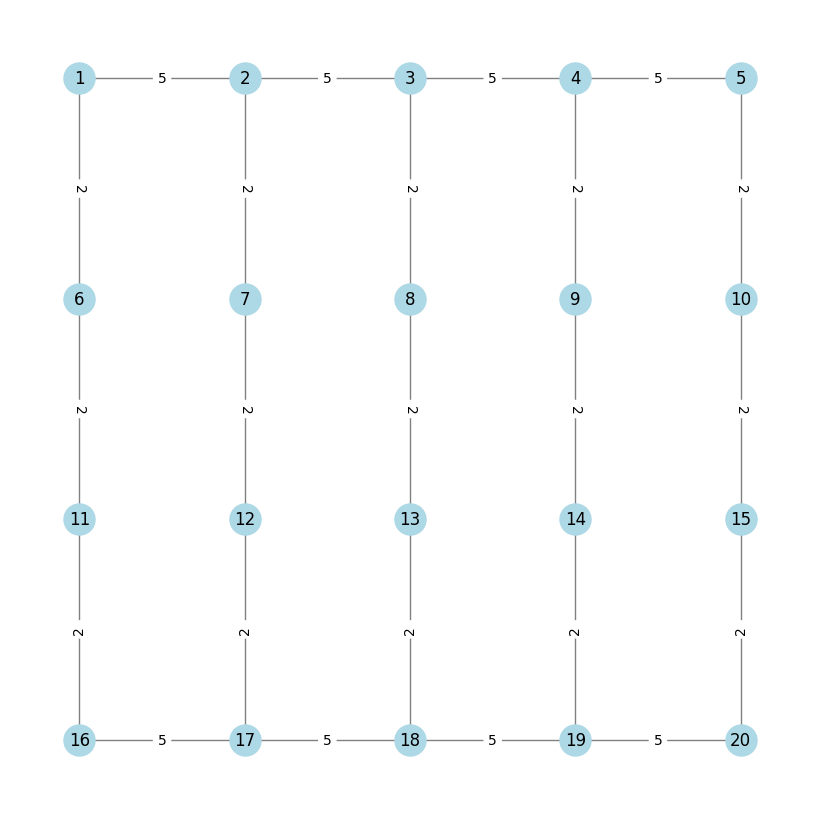

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.Graph()

# Define grid dimensions
n = 5  # Number of rows
m = 4  # Number of columns
n_bins = n * m

# Add edges within rows
for i in range(1, n):
    G.add_edge(i, i + 1, weight=5)

for i in range(n * m - n + 1, n * m):
    G.add_edge(i, i + 1, weight=5)

# Add edges between rows
for i in range(1, n * m - n + 1):
    G.add_edge(i, i + n, weight=2)

# Visualize the graph
pos = {}
for row in range(m):  # m is the number of rows
    for col in range(n):  # n is the number of columns
        node = row * n + col + 1
        pos[node] = (col, -row)  # Arrange nodes in a square grid

# Highlight the shortest path in the visualization
plt.figure(figsize=(8, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    edge_color="gray",
)

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)},
    font_size=10,
    label_pos=0.5,
)
plt.axis("off")
plt.show()

# Assign fruit to bins

In [4]:
# new column with random integer
df["bin"] = np.random.randint(1, n_bins, df.shape[0])

In [5]:
# Generate work orders
wos = 100

# Check if wos file is already generated
if f"wos_{wos}.parquet" in os.listdir():
    df_wo = pd.read_parquet(f"wos_{wos}.parquet")
    print(f"Loaded {df_wo.shape[0]} work orders")
else:
    print(f"Generating {wos} work orders")
    df_wo = pd.DataFrame(columns=df.columns)
    for _ in range(wos):
        random_row = df.sample()
        df_wo = pd.concat([df_wo, random_row], ignore_index=True)
    df_wo.to_parquet(f"wos_{wos}.parquet")
df_wo.head()

Loaded 100 work orders


,Name,Category,bin
0,Japanese plum,Fruit,19
1,Mandarine,Fruit,5
2,Cherimoya (Custard Apple),Fruit,16
3,Grape,Fruit,10
4,Cucumber,Fruit,5


In [6]:
batch_size = 10
fetch_list = []
for i in range(int(np.floor(df_wo.count().Category) / batch_size)):
    fetch_list.append(df_wo.loc[i * 10 : i * 10 + 10])

In [7]:
# Traveling Salesman applied to a pickup list
salesman = []
pickup_point = [1]
for i in fetch_list:
    pickup_list = pickup_point + i.bin.values.tolist()
    tsp = nx.approximation.traveling_salesman_problem
    tsp_route = tsp(G, nodes=pickup_list)
    tsp_distance = sum(G[u][v]["weight"] for u, v in zip(tsp_route, tsp_route[1:]))
    seen = set()
    order = [
        node
        for node in tsp_route
        if node in pickup_list and not (node in seen or seen.add(node))
    ][1:]

    salesman.append(
        {
            "pickup_list": pickup_list,
            "tsp_route": tsp_route,
            "tsp_distance": tsp_distance,
            "pickup_order": order,
        }
    )
# Convert salesman list to dataframe
df_salesman = pd.DataFrame(salesman)
df_salesman.head()

,pickup_list,tsp_route,tsp_distance,pickup_order
0,"[1, 19, 5, 16, 10, 5, 3, 10, 6, 12, 2, 19]","[1, 2, 7, 12, 7, 2, 3, 4, 5, 10, 15, 20, 19, 1...",60,"[2, 12, 3, 5, 10, 19, 16, 6]"
1,"[1, 19, 4, 5, 15, 6, 7, 2, 15, 4, 1, 18]","[1, 2, 7, 12, 17, 18, 19, 14, 9, 4, 5, 10, 15,...",64,"[2, 7, 18, 19, 4, 5, 15, 6]"
2,"[1, 18, 7, 5, 14, 8, 2, 6, 7, 5, 2, 3]","[1, 2, 3, 8, 13, 18, 19, 14, 9, 4, 5, 4, 3, 2,...",60,"[2, 3, 8, 18, 14, 5, 7, 6]"
3,"[1, 3, 16, 15, 5, 19, 10, 2, 18, 6, 7, 6]","[1, 2, 3, 4, 5, 10, 15, 20, 19, 18, 13, 8, 3, ...",64,"[2, 3, 5, 10, 15, 19, 18, 7, 16, 6]"
4,"[1, 6, 8, 10, 6, 5, 14, 2, 6, 6, 5, 2]","[1, 2, 3, 8, 13, 18, 19, 14, 9, 4, 5, 10, 5, 4...",60,"[2, 8, 14, 5, 10, 6]"


In [8]:
# Stats
print(f"Total number of work orders: {df_wo.count().Category}")
print(f"Total number of batches: {len(fetch_list)}")
print(f"Average Distance: {df_salesman.tsp_distance.mean()}")

Total number of work orders: 100
Total number of batches: 10
Average Distance: 60.6


# Generating a more complex warehouse

In [57]:
class Grid:
    def __init__(self, grid, waypoints, scale=1):
        self.grid = grid
        self.waypoints = waypoints
        self.scale = scale
        self.G = nx.Graph()
        self.make_graph()

    def make_graph(self):
        x_shape = self.grid.shape[1]
        for n, pos in enumerate(np.ndindex(self.grid.shape)):
            x = pos[1]
            y = pos[0]
            if self.grid[pos] == 1:
                self.G.add_node(n, pos=(x, -y))
                # Add edged to north and west neighbors if pathway
                if x > 0 and self.grid[y, x - 1] == 1:
                    self.G.add_edge(n, n - 1, weight=self.scale)
                if y > 0 and self.grid[y - 1, x] == 1:
                    north_neighbor = n - x_shape
                    self.G.add_edge(n, north_neighbor, weight=self.scale)

    def pos2node(self, pos: tuple):
        return pos[1] * self.grid.shape[1] + pos[0]

    def node2pos(self, node: int):
        return (node // self.grid.shape[1], node % self.grid.shape[1])

    def find_path(self, start: str, end: str, model: str = "dijkstra"):
        start = self.pos2node(self.waypoints[start])
        end = self.pos2node(self.waypoints[end])
        if model == "astar":

            def heuristic(a, b):
                x1, y1 = self.G.nodes[a]["pos"]
                x2, y2 = self.G.nodes[b]["pos"]
                return np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))

            return nx.astar_path(
                self.G, start, end, heuristic=heuristic, weight="weight"
            )
        elif model == "dijkstra":
            try:
                path = nx.shortest_path(self.G, start, end)
            except:
                print("No path found")
                path = []
            return path

    def plot(self, path=None):
        plt.imshow(self.grid, cmap="gray")
        plt.grid(True)

        for key, (x, y) in self.waypoints.items():
            plt.plot(x, y, "go")
            plt.text(x, y, key, fontsize=12, ha="right")
        if path:
            # Plot the path
            path_coords = [self.node2pos(wp) for wp in path]
            path_coords = np.array(path_coords)
            plt.plot(path_coords[:, 1], path_coords[:, 0], "r-")
        plt.show()

    def plot_graph(self):
        pos = nx.get_node_attributes(self.G, "pos")
        nx.draw(
            self.G,
            pos=pos,
            with_labels=True,
            node_size=200,
            node_color="lightblue",
            edge_color="gray",
        )
        plt.show()

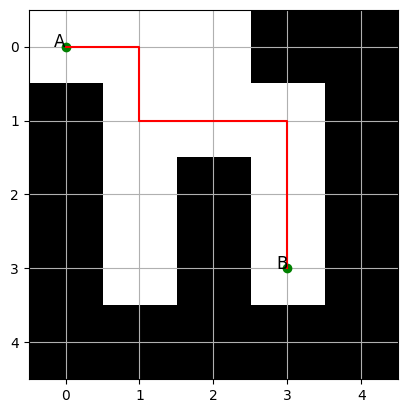

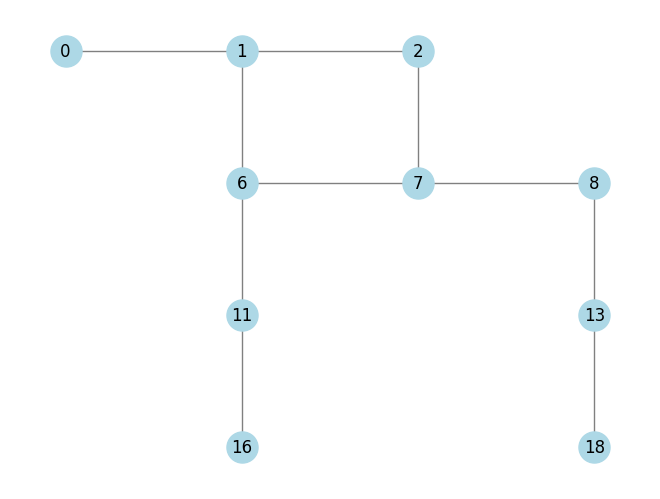

[0, 1, 6, 7, 8, 13, 18]

In [10]:
grid = np.array(
    [
        [1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
    ]
)

waypoints = {
    "A": (0, 0),
    "B": (3, 3),
}

g = Grid(grid, waypoints)
path = g.find_path("A", "B")
g.plot(path)
g.plot_graph()
path

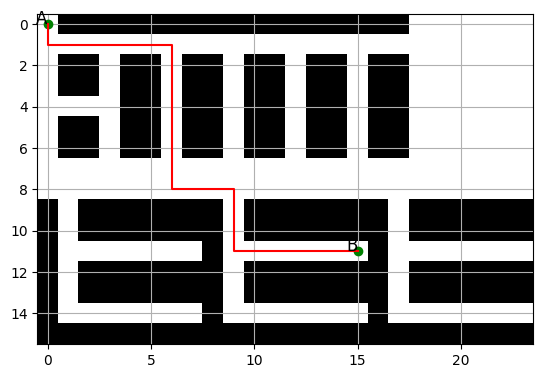

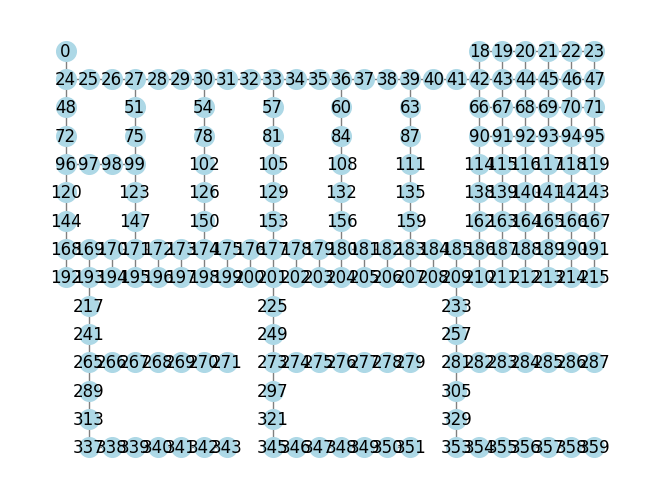

[0,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 54,
 78,
 102,
 126,
 150,
 174,
 198,
 199,
 200,
 201,
 225,
 249,
 273,
 274,
 275,
 276,
 277,
 278,
 279]

In [59]:
grid = np.loadtxt("fruteria.csv", delimiter=",", dtype=int)
%matplotlib inline
waypoints = {
    "A": (0, 0),
    "B": (15, 11),
}

g = Grid(grid, waypoints, scale=0.5)
path = g.find_path("A", "B")
g.plot(path)
g.plot_graph()
print(path)